In [1]:
import sys, os
import numpy as np
import torch
import yaml
import pickle as pk
# autoreload modules
%load_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL
import pickle as pk
import readfof
import matplotlib

import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline



%load_ext Cython


        
        
        



In [2]:
import readfof
import sys, os
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
import yaml
# import galactic_wavelets as gw



In [3]:
df = pk.load(open('/mnt/home/spandey/ceph/CHARFORMER/data/df_halo_part_ngp_xyzM_tokenized_density3Dgrid_32_isim_3_snap_3.pkl','rb'))

dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_0 = df['dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed']
dfhalo_ngp_wxyzM_0 = df['dfhalo_ngp_wxyzM']
Nhalos_truth_0 = df['Nhalos_truth']
delta_box_all_squeezed_0 = df['delta_box_all_squeezed']




In [4]:
grid = 32
shift_x_all, shift_y_all, shift_z_all = np.zeros((grid, grid, grid)), np.zeros((grid, grid, grid)), np.zeros((grid, grid, grid))
for jx in range(grid):
    for jy in range(grid):
        for jz in range(grid):
            shift_x_all[jx, jy, jz] = jx
            shift_y_all[jx, jy, jz] = jy
            shift_z_all[jx, jy, jz] = jz

shift_x_all_squeezed, shift_y_all_squeezed, shift_z_all_squeezed = shift_x_all.flatten(), shift_y_all.flatten(), shift_z_all.flatten()
shift_all_squeezed = np.vstack([shift_x_all_squeezed, shift_y_all_squeezed, shift_z_all_squeezed]).T



In [5]:
dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_0.shape, delta_box_all_squeezed_0.shape


((32768, 161), (32768, 32, 32, 32, 3))

In [6]:
from test_ddp import *


In [7]:
dev = torch.device("cuda")
model = HaloDecoderModel(HaloConfig).to(dev)
# if rank == 0: print(f"Init model and loaded to GPU", flush=True)            
# model.to(device).bfloat16()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))



number of parameters: 0.40M


In [8]:
checkpoint = torch.load('/mnt/home/spandey/ceph/CHARFORMER/model_checkpoints/model_encdec_testddp.pt')



In [9]:
model.load_state_dict(checkpoint['model'])



<All keys matched successfully>

In [10]:
model.eval()
print()

In [11]:
n1 = 32**3
test_data_halos = dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_0[:n1]

test_data_dm = delta_box_all_squeezed_0[:n1]

x = torch.tensor(test_data_halos[:, :-1])
y = torch.tensor(test_data_halos[:, 1:])
dm = torch.tensor(test_data_dm)
mask_test_orig = x != 1
mask_test = torch.logical_not(mask_test_orig)
masked_logits = torch.zeros(mask_test.shape)
mask_test_final = masked_logits.masked_fill(mask_test, float('-inf'))
mask_test = mask_test_final[:,None,:]
x, y = torch.tensor(x), torch.tensor(y)
x_test = x.long()
y_test = y.long()
dm_test = dm.bfloat16()
mask_test = torch.tensor(mask_test).bfloat16()




/tmp/ipykernel_453754/1321212745.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x), torch.tensor(y)
/tmp/ipykernel_453754/1321212745.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_test = torch.tensor(mask_test).bfloat16()


In [12]:
dm_test.shape


torch.Size([32768, 32, 32, 32, 3])

In [13]:
x_test_gpu = x_test.to(dev)
y_test_gpu = y_test.to(dev)
dm_test_gpu = dm_test.to(dev)
mask_test_gpu = mask_test.to(dev)




In [14]:
def get_batch(split, ji=0, batch_size=None):
    if split == 'train':
        x = x_train_gpu
        y = y_train_gpu
        mask = mask_train_gpu
        dm = dm_train_gpu

    elif split == 'val':
        x = x_val_gpu
        y = y_val_gpu
        mask = mask_val_gpu
        dm = dm_val_gpu

    elif split == 'test':
        x = x_test_gpu
        y = y_test_gpu
        mask = mask_test_gpu
        dm = dm_test_gpu        

    if batch_size is not None:
        x = x[batch_size*(ji):batch_size*(ji+1)].to(dev, non_blocking=True)
        y = y[batch_size*(ji):batch_size*(ji+1)].to(dev, non_blocking=True)
        mask = mask[batch_size*(ji):batch_size*(ji+1)].to(dev, non_blocking=True)
        dm = dm[batch_size*(ji):batch_size*(ji+1)].to(dev, non_blocking=True)

    return x, y, mask, dm

    

In [15]:
batch_size = 32**3
X_val, Y_val, MASK_val, DM_val = get_batch('test', 0, batch_size)
DM_val = torch.moveaxis(DM_val, -1, 1)
# DM_val.shape



In [16]:
DM_val.shape

torch.Size([32768, 3, 32, 32, 32])

In [17]:
DM_val_tosplit = DM_val.detach().cpu().to(torch.float16).numpy()[:batch_size, 0,:,:,:].reshape(batch_size, DM_val.shape[-1]**3)
DM_val_tosplit_mean = np.mean(DM_val_tosplit, axis=-1)



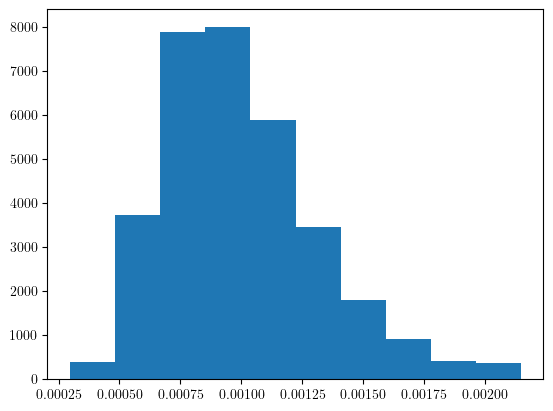

In [18]:

pl.figure()
_ = pl.hist(DM_val_tosplit_mean)



In [19]:
vlow = 0.00075
vmid = 0.0017

indlow = np.where(DM_val_tosplit_mean < vlow)[0]
indmid = np.where((DM_val_tosplit_mean >= vlow) & (DM_val_tosplit_mean < vmid))[0]
indhigh = np.where(DM_val_tosplit_mean >= vmid)[0]

print(len(indlow), len(indmid), len(indhigh))




7331 24383 1054


In [20]:
model = model.bfloat16()


In [21]:
# max_new_tokens = 160
# end_token = 129
# nvox_samp = 1024
# nbatches = 32
# nvox_per_batch = nvox_samp // nbatches

# # jb = 0
# # idx_inp = torch.zeros((nvox_per_batch, 1), dtype=torch.long, device=dev)
# # DM_val_jb = DM_val[jb*nvox_per_batch:(jb+1)*nvox_per_batch,...]

# # idx = idx_inp



In [22]:
# # crop idx to the last block_size tokens
# # idx_cond = idx[:, -block_size:]
# idx_cond = idx
# # get the predictions
# logits, loss = model(idx_cond, DM_val_jb)
# # focus only on the last time step
# logits = logits[:, -1, :] # becomes (B, C)
# # apply softmax to get probabilities
# probs = F.softmax(logits, dim=-1) # (B, C)
# # sample from the distribution
# idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)



In [23]:
# idx_next.shape
32**3/32


1024.0

In [24]:
from tqdm import tqdm
max_new_tokens = 160
end_token = 129
nvox_samp = 32**3
nbatches = 32
nvox_per_batch = nvox_samp // nbatches

# idx_all = []
# idx_all = torch.ones((nvox_samp, max_new_tokens), dtype=torch.long, device=dev)
idx_all = np.ones((nvox_samp, max_new_tokens))
for jb in tqdm(range(nbatches)):

    idx_inp = torch.zeros((nvox_per_batch, 1), dtype=torch.long, device=dev)

    DM_val_jb = DM_val[jb*nvox_per_batch:(jb+1)*nvox_per_batch,...]

    new_samples_jb = np.ones((nvox_per_batch, max_new_tokens))

    ind_jb = np.arange(nvox_per_batch)

    new_samples_jb[:, 0] = idx_inp[:,0].cpu().detach().numpy()
    # idx = idx_inp
    for jt in range(1, max_new_tokens):
        # crop idx to the last block_size tokens
        idx_cond = torch.tensor(new_samples_jb[ind_jb, :jt], dtype=torch.long, device=dev)
        # get the predictions
        logits, loss = model(idx_cond, DM_val_jb[ind_jb,...])
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1).cpu().detach().numpy() # (B, 1)

        # append sampled index to the running sequence
        # if idx_next == end_token:
            # break
        new_samples_jb[ind_jb, jt] = idx_next[:,0]
        ind_to_del = np.where(idx_next == end_token)[0]
        # for jv in range(len(ind_jb)):
            # if idx_next[jv, 0] == end_token:
        if len(ind_to_del) > 0:
            ind_jb = np.delete(ind_jb, ind_to_del)


        # print(new_samples_jb[0,:])
        # idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    idx_all[jb*nvox_per_batch:(jb+1)*nvox_per_batch, :] = new_samples_jb
    # idx_all.append(idx)




100%|██████████| 32/32 [03:49<00:00,  7.17s/it]


In [25]:
X_val.shape, idx_all.shape




(torch.Size([32768, 160]), (32768, 160))

In [27]:
# idx_all[0,:]
# new_samples_jb.shape, idx_inp.shape
# 2+2

# idx_all
# idx_next.shape, ind_jb.shape
# ind_jb

# idx_next

In [28]:
# from tqdm import tqdm
# idx_inp = torch.zeros((1, 1), dtype=torch.long, device=dev)
# # nvox_samp = len(indhigh)
# nvox_samp = 1024
# max_new_tokens = 160
# end_token = 129
# idx_all = []
# for jv in tqdm(range(nvox_samp)):
#     ind_jv = indhigh[jv]
#     DM_val_jv = DM_val[ind_jv,...]
#     idx = idx_inp
#     for _ in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits, loss = model(idx_cond, DM_val_jv.unsqueeze(0))
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)
#         # apply softmax to get probabilities
#         probs = F.softmax(logits, dim=-1) # (B, C)
#         # sample from the distribution
#         idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
#         # append sampled index to the running sequence
#         if idx_next == end_token:
#             break
#         idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
#     idx_all.append(idx)
    

In [26]:
Mmin_cut = 1e13
lgMin = np.log10(Mmin_cut)
lgMax = 15.5

BoxSize = 1000.
grid = 32
xmin = BoxSize/grid/2




In [27]:
nvocab = 128
bins_digitize = np.linspace(-1e-3, 1, nvocab)
# bins_digitize.insert(0, -1)
bins_digitize = np.insert(bins_digitize, 0, -1)


start_token = 0
pad_token = 1
end_token = nvocab + 1
space_token = nvocab + 2


In [28]:
# nvox_samp


In [110]:
Nhalo_all_truth = []
Mhalo_all_truth = []
pos_all_truth = []
Pk_all_truth = []

MAS     = 'NGP'  #mass-assigment scheme
grid_Pk = 16
threads = 10

for jv in range(nvox_samp):
# for jv in indhigh[:nvox_samp]:    
    idx = X_val[jv]
    idx = idx.cpu().numpy().flatten().astype(int)
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        Nhalo = len(idxe) + len(idx0)
        Nhalo_all_truth.append(Nhalo)
        pos_halo = np.zeros((Nhalo, 3))
        pos_halo_unshifted = np.zeros((Nhalo, 3))        
        if Nhalo > 0:
            try:
                Mhalo = np.zeros(Nhalo)
                for jh in range(Nhalo):
                    if jh == 0:
                        Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                        for jx in range(3):
                            # if jx == 0:
                            shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                            pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin  + shift_coord        
                            pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                    else:
                        if Nhalo > 2:
                            Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin  + shift_coord
                                pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                        else:
                            Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin  + shift_coord    
                                pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                Mhalo_all_truth.append(Mhalo)
                pos_all_truth.append(pos_halo)

                if Nhalo > 5:
                    mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                    MASL.MA(pos_halo_unshifted.astype(np.float32), mesh_truth, 2*xmin, MAS)
                    mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                    Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                    Pk_all_truth.append(Pk_truth.Pk[:,0])
                else:
                    Pk_all_truth.append([])

            except:
                Mhalo_all_truth.append(np.array([]))
                pos_all_truth.append(np.array([]))
                Pk_all_truth.append([])
                pass
        else:
            Mhalo_all_truth.append(np.array([]))
            pos_all_truth.append(np.array([]))
            Pk_all_truth.append([])
    else:
        Nhalo_all_truth.append(np.array([]))
        Mhalo_all_truth.append(np.array([]))
        pos_all_truth.append(np.array([]))
        Pk_all_truth.append([])


/tmp/ipykernel_453754/921544037.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_453754/921544037.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin  + shift_coord
/tmp/ipykernel_453754/921544037.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
/tmp/ipyk

In [111]:
idx0, idxe


(array([1]), array([ 6, 11, 16]))

In [112]:
Nhalo_all = []
Mhalo_all = []
pos_all = []
Pk_all = []


for jv in range(nvox_samp):
# for jv in indhigh[:nvox_samp]:    
    idx = idx_all[jv].astype(int)
    idx = idx.flatten()
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        Nhalo = len(idxe) + len(idx0)
        Nhalo_all.append(Nhalo)
        pos_halo = np.zeros((Nhalo, 3))
        pos_halo_unshifted = np.zeros((Nhalo, 3))
        if Nhalo > 0:
            try:
                Mhalo = np.zeros(Nhalo)
                for jh in range(Nhalo):
                    if jh == 0:
                        Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                        for jx in range(3):
                            shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                            pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin + shift_coord    
                            pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                    else:
                        if Nhalo > 2:
                            Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin  + shift_coord   
                                pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                        else:
                            Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin  + shift_coord 
                                pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord


                Mhalo_all.append(Mhalo)
                pos_all.append(pos_halo)

                if Nhalo > 5:
                    mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                    MASL.MA(pos_halo_unshifted.astype(np.float32), mesh_truth, 2*xmin, MAS)
                    mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                    Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                    Pk_all.append(Pk_truth.Pk[:,0])
                else:
                    Pk_all.append([])


            except Exception as e:
                Mhalo_all.append(np.array([]))
                pos_all.append(np.array([]))
                Pk_all.append([])
                print(jv, e)
                pass

        else:
            Mhalo_all.append(np.array([]))
            pos_all.append(np.array([]))
            Pk_all.append([])

    else:
        Nhalo_all.append(np.array([]))
        Mhalo_all.append(np.array([]))
        pos_all.append(np.array([]))
        Pk_all.append([])



/tmp/ipykernel_453754/522719373.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_453754/522719373.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin + shift_coord
/tmp/ipykernel_453754/522719373.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
/tmp/ipyke

1756 index 129 is out of bounds for axis 0 with size 129
5024 index 129 is out of bounds for axis 0 with size 129
7485 index 129 is out of bounds for axis 0 with size 129
9604 index 130 is out of bounds for axis 0 with size 129
10084 index 130 is out of bounds for axis 0 with size 129
16605 index 130 is out of bounds for axis 0 with size 129
17976 index 130 is out of bounds for axis 0 with size 129
19488 index 129 is out of bounds for axis 0 with size 129
19893 index 130 is out of bounds for axis 0 with size 129
21024 index 129 is out of bounds for axis 0 with size 129
21149 index 129 is out of bounds for axis 0 with size 129
25254 index 130 is out of bounds for axis 0 with size 129
25494 index 130 is out of bounds for axis 0 with size 129
26913 index 130 is out of bounds for axis 0 with size 129
28003 index 130 is out of bounds for axis 0 with size 129
29258 index 129 is out of bounds for axis 0 with size 129


In [113]:
idx_all[5024]



array([  0.,  65.,  23.,   4.,  12., 130.,  21., 110.,  32., 124., 130.,
        13.,  46., 116.,  55., 130.,  12., 126.,  64.,  24., 130.,   3.,
       129.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   

Text(0, 0.5, '$P_{\\rm mock}(k)/P_{\\rm truth}(k)$')

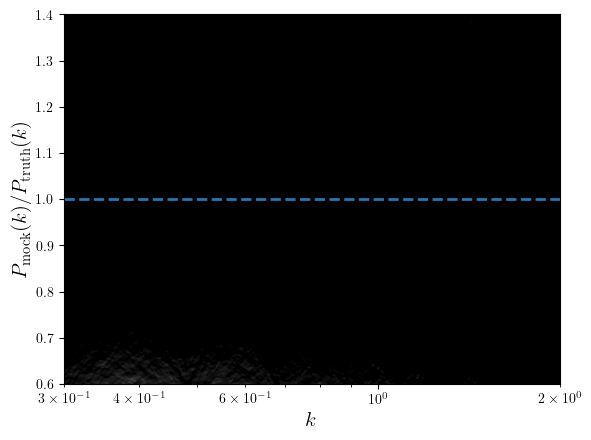

In [139]:
pl.figure()
resid_all = []
# for jp in range(len(Pk_all)):
# for jp in indhigh:    
Pk_all_concat = []
Pk_all_truth_concat = []
# for jp in indlow:        
# for jp in indhigh:       
for jp in range(nvox_samp):
# for jp in indmid[::10]:            
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        # pl.plot(Pk_truth.k3D, (Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp], color='k', ls='-', alpha=0.0003)
        pl.plot(Pk_truth.k3D, (Pk_all[jp])/(Pk_all_truth[jp]), color='k', ls='-', alpha=0.03)
        resid_all.append((Pk_all[jp])/Pk_all_truth[jp])
        Pk_all_concat.append(Pk_all[jp])
        Pk_all_truth_concat.append(Pk_all_truth[jp])

Pk_all_concat = np.vstack(Pk_all_concat)
Pk_all_truth_concat = np.vstack(Pk_all_truth_concat)

resid_all = np.vstack(resid_all)
pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.6, 1.4)
pl.xlim(0.3, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)




Text(0.5, 1.0, 'Power spectra of 32Mpc/$h$ sub-boxes')

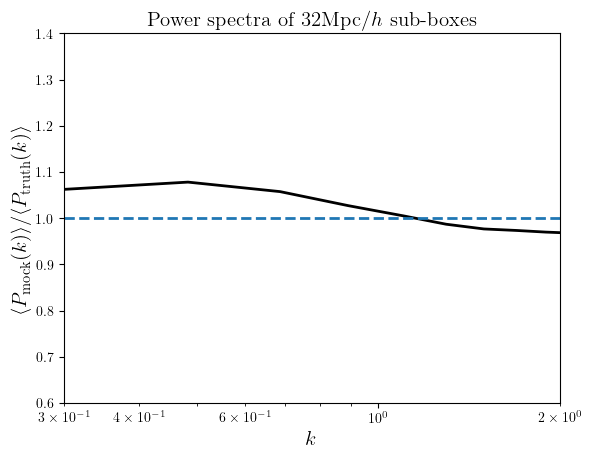

In [143]:
pl.figure()
pl.plot(Pk_truth.k3D, np.mean(Pk_all_concat, axis=0)/np.mean(Pk_all_truth_concat, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.6, 1.4)
pl.xlim(0.3, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$\langle P_{\rm mock}(k) \rangle/\langle P_{\rm truth}(k) \rangle$', size=15)
pl.title(r'Power spectra of 32Mpc/$h$ sub-boxes', size=15)




In [102]:
# pl.figure()
# resid_all = []
# # for jp in range(len(Pk_all)):
# # for jp in indhigh:    
# for jp in indlow:        
#     if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
#         # pl.plot(Pk_truth.k3D, (Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp], color='k', ls='-', alpha=0.0003)
#         pl.plot(Pk_truth.k3D, (Pk_all[jp])/(Pk_all_truth[jp]), color='k', ls='-', alpha=0.03)
#         resid_all.append((Pk_all[jp])/Pk_all_truth[jp])

# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
# pl.axhline(1.0, ls='--', lw=2.0)
# pl.xscale('log')
# pl.ylim(0.6, 1.4)
# pl.xlim(0.3, 2)
# # pl.scale('log')
# pl.xlabel(r'$k$', size=15)
# pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)




In [117]:
Nhalo_all_truth_concat = []
for jv in range(len(Nhalo_all_truth)):
    if type(Nhalo_all_truth[jv]) == int:
        Nhalo_all_truth_concat.append(Nhalo_all_truth[jv])

Nhalo_all_concat = []
for jv in range(len(Nhalo_all)):
    if type(Nhalo_all[jv]) == int:
        Nhalo_all_concat.append(Nhalo_all[jv])  

    

    

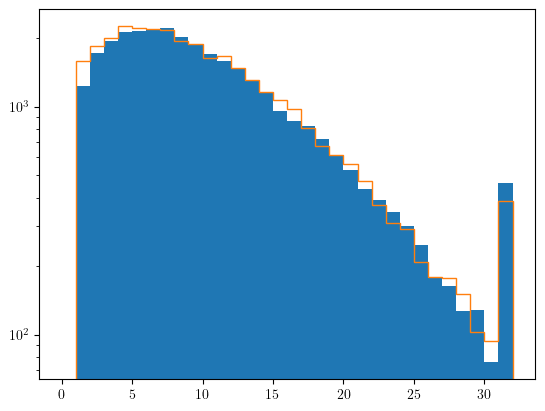

In [119]:
# np.array(Nhalo_all_truth_concat).shape
pl.figure()
_ = pl.hist(np.array(Nhalo_all_truth_concat), range=(0,32), bins=32)
_ = pl.hist(np.array(Nhalo_all_concat), range=(0,32), bins=32, histtype='step')
pl.yscale('log')




In [70]:
Mhalo_all_truth_concat = []
for jv in range(len(Mhalo_all_truth)):
    Mhalo_all_truth_concat.extend(Mhalo_all_truth[jv])

Mhalo_all_concat = []
for jv in range(len(Mhalo_all)):
    Mhalo_all_concat.extend(Mhalo_all[jv])  

    

In [71]:
pos_all_truth_concat = []
for jv in range(len(pos_all_truth)):
    if len(pos_all_truth[jv]) > 0:
        if len(pos_all_truth_concat) == 0:
            pos_all_truth_concat = pos_all_truth[jv]
        else:
            pos_all_truth_concat = np.vstack((pos_all_truth_concat, pos_all_truth[jv]))
        # pos_all_truth_concat.extend(pos_all_truth[jv])


    

In [72]:
pos_all_concat = []
for jv in range(len(pos_all)):
    if len(pos_all[jv]) > 0:
        if len(pos_all_concat) == 0:
            pos_all_concat = pos_all[jv]
        else:
            pos_all_concat = np.vstack((pos_all_concat, pos_all[jv]))
        # pos_all_concat.extend(pos_all[jv])  



In [73]:
# np.amin(pos_all_truth_concat[:,2]), np.amax(pos_all_truth_concat[:,2])
np.amin(pos_all_concat[:,2]), np.amax(pos_all_concat[:,2])
# pos_all_truth_concat.shape



(0.21505905511811022, 1000.0)

Text(0.5, 1.0, 'Halos Mock (tokenized)')

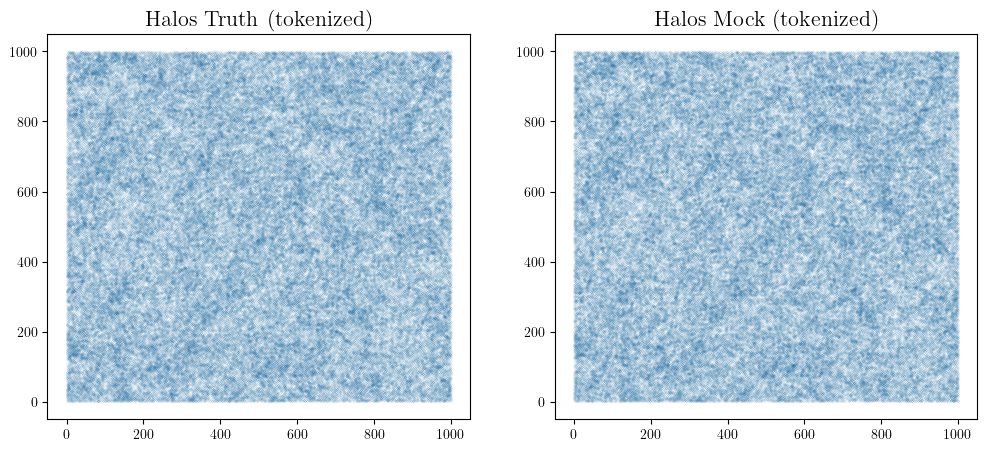

In [137]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 5))
# fig.suptitle('Horizontally stacked subplots')
# ax1.plot(x, y)
# ax2.plot(x, -y)
ax1.scatter(pos_all_truth_concat[:,0], pos_all_truth_concat[:,1], s=0.001)
ax1.set_title('Halos Truth (tokenized)', size=16)

# fig.add_subplot(121)
ax2.scatter(pos_all_concat[:,0], pos_all_concat[:,1], s=0.001)
ax2.set_title('Halos Mock (tokenized)', size=16)



Text(0.5, 1.0, 'Halos Mock (tokenized)')

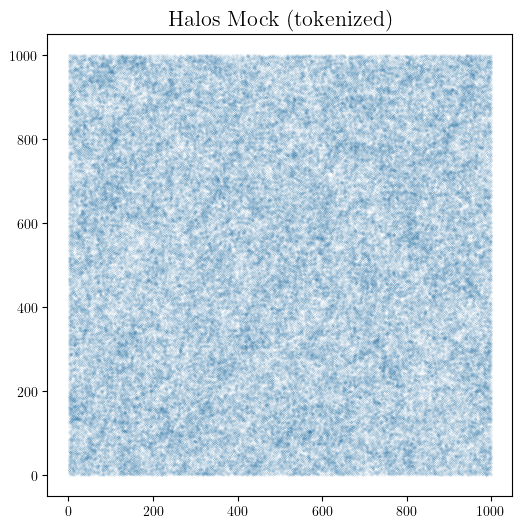

In [127]:
pl.figure(figsize=(6,6))
pl.scatter(pos_all_concat[:,0], pos_all_concat[:,1], s=0.001)
pl.title('Halos Mock (tokenized)', size=16)


In [88]:
isim_fid = 4
snapnum = 3
mass_type = 'rockstar_200c'
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'
snapdir = snap_dir_base + '/' + str(isim_fid)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
if mass_type == 'rockstar_vir':
    index_M = header.index('Mvir')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
if mass_type == 'rockstar_200c':
    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

Mmin_cut = 1e13
lgMass_truth = np.log10(mass_truth)
indsel = np.where(mass_truth > Mmin_cut)[0]
# print(grid, len(indsel), len(mass_truth), np.amin(lgMass_truth), np.log10(Mmin_cut))
pos_h_truth_orig = pos_h_truth[indsel]
lgMass_truth_orig = lgMass_truth[indsel]



/tmp/ipykernel_453754/1533666262.py:20: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth)


In [177]:
Mmin_Pk, Mmax_Pk = 14.0, 14.5



In [178]:
grid_Pk_full = 512
threads = 10
MAS = 'CIC'
mesh_truth = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
indsel_M = np.where((lgMass_truth_orig > Mmin_Pk) & (lgMass_truth_orig < Mmax_Pk))[0]
print(f'Number of halos in original true cat {len(indsel_M)}')
MASL.MA(pos_h_truth_orig[indsel_M].astype(np.float32), mesh_truth, 1000., MAS)
mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
Pk_truth_full_orig = PKL.Pk(mesh_truth, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)



Number of halos in original true cat 9888


In [179]:
# grid_Pk_full = 512
threads = 10
MAS = 'CIC'
mesh_truth = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
indsel_M = np.where((np.array(Mhalo_all_truth_concat) > Mmin_Pk) & (np.array(Mhalo_all_truth_concat) < Mmax_Pk))[0]
print(f'Number of halos in tokenized true cat {len(indsel_M)}')
MASL.MA(pos_all_truth_concat[indsel_M].astype(np.float32), mesh_truth, 1000., MAS)
mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
Pk_truth_full = PKL.Pk(mesh_truth, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)




Number of halos in tokenized true cat 10546


In [180]:
# grid_Pk = 512
threads = 10
MAS = 'CIC'
mesh_mock = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
indsel_M = np.where((np.array(Mhalo_all_concat) > Mmin_Pk) & (np.array(Mhalo_all_concat) < Mmax_Pk))[0]
print(f'Number of halos in tokenized mock cat {len(indsel_M)}')
MASL.MA(pos_all_concat[indsel_M].astype(np.float32), mesh_mock, 1000., MAS)
mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
Pk_mock_full = PKL.Pk(mesh_mock, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)




Number of halos in tokenized mock cat 10559


Text(0.5, 1.0, '14.5$ < \\log({M}) <$16.0')

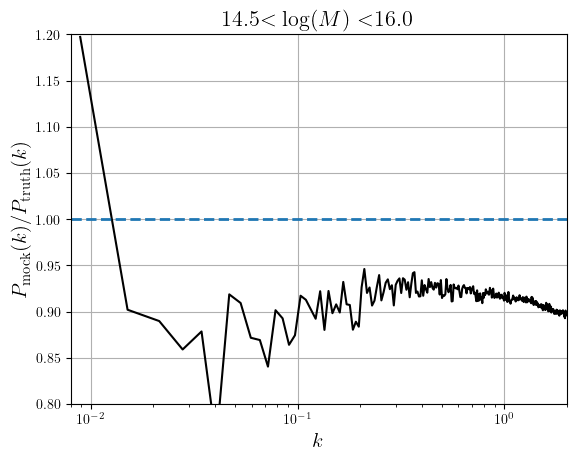

In [173]:
pl.figure()
pl.plot(Pk_truth_full.k3D, Pk_mock_full.Pk[:,0]/Pk_truth_full.Pk[:,0], color='k', ls='-', alpha=1.0)
# pl.plot(Pk_truth_full.k3D, Pk_mock_full.Pk[:,0]/Pk_truth_full_orig.Pk[:,0], color='k', ls='-', alpha=1.0)
# pl.plot(Pk_truth_full.k3D, Pk_truth_full.Pk[:,0]/Pk_truth_full_orig.Pk[:,0], color='k', ls='-', alpha=1.0)
# pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], color='r', ls='--', alpha=1.0)

# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
# pl.yscale('log')
pl.ylim(0.8, 1.2)
pl.xlim(0.008, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.grid()
# pl.ylabel(r'$\Delta P(k)/P(k)$', size=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(str(Mmin_Pk) + r'$ < \log({M}) <$' + str(Mmax_Pk), size=16)



In [150]:
Pk_truth_mock_full = PKL.XPk([mesh_mock, mesh_truth], 1000., axis=0, MAS=[MAS, MAS], threads=threads)



Computing power spectra of the fields...
Time FFTS = 1.14
Time loop = 2.83
Time taken = 3.97 seconds


In [151]:
# Pk_mock.Pk[:,0]
# Pk0_X  = Pk_truth_mock_full.XPk[:,0,0] #monopole of 1-2 cross P(k)



Text(0, 0.5, '$r(k) = P_{\\rm truth \\times mock}/\\sqrt{P_{\\rm truth} \\times P_{\\rm mock}}$')

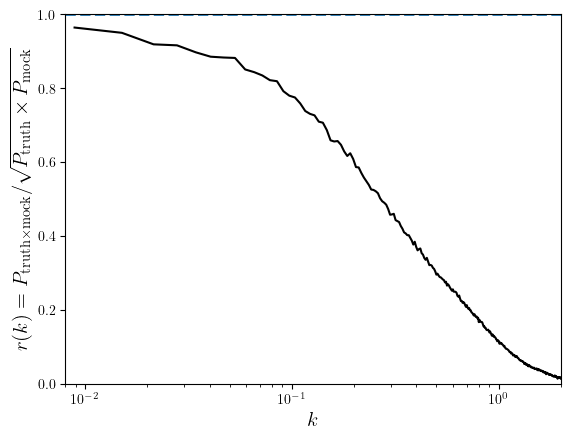

In [152]:
pl.figure()
pl.plot(Pk_truth_full.k3D, Pk_truth_mock_full.XPk[:,0,0]/np.sqrt(Pk_truth_full.Pk[:,0] * Pk_mock_full.Pk[:,0]), color='k', ls='-', alpha=1.0)
# pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], color='r', ls='--', alpha=1.0)

# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
# pl.yscale('log')
pl.ylim(0.0, 1.0)
pl.xlim(0.008, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$r(k) = P_{\rm truth \times mock}/\sqrt{P_{\rm truth} \times P_{\rm mock}}$', size=15)




Text(0.5, 1.0, '13.0$ < \\log({M}) <$13.5')

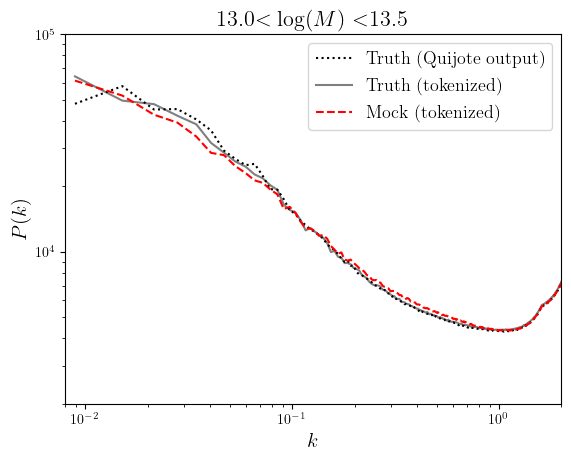

In [153]:
pl.figure()
pl.plot(Pk_truth_full.k3D, Pk_truth_full_orig.Pk[:,0], color='k', ls=':', alpha=1.0, label='Truth (Quijote output)')
pl.plot(Pk_truth_full.k3D, Pk_truth_full.Pk[:,0], color='k', ls='-', alpha=0.5, label='Truth (tokenized)')
pl.plot(Pk_mock_full.k3D, Pk_mock_full.Pk[:,0], color='r', ls='--', alpha=1.0, label='Mock (tokenized)')

# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
# pl.axhline(0.0, ls='--', lw=2.0)
pl.xscale('log')
pl.yscale('log')
pl.legend(fontsize=13)
pl.ylim(2e3, 1e5)
pl.xlim(0.008, 2)

# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$P(k)$', size=15)
pl.title(str(Mmin_Pk) + r'$ < \log({M}) <$' + str(Mmax_Pk), size=16)




Text(0.5, 1.0, '13.0$ < \\log({M}) <$13.5')

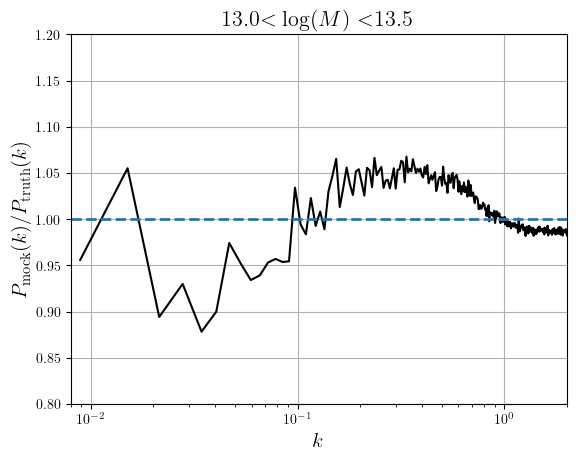

In [157]:
pl.figure()
pl.plot(Pk_truth_full.k3D, Pk_mock_full.Pk[:,0]/Pk_truth_full.Pk[:,0], color='k', ls='-', alpha=1.0)
# pl.plot(Pk_truth_full.k3D, Pk_mock_full.Pk[:,0]/Pk_truth_full_orig.Pk[:,0], color='k', ls='-', alpha=1.0)
# pl.plot(Pk_truth_full.k3D, Pk_truth_full.Pk[:,0]/Pk_truth_full_orig.Pk[:,0], color='k', ls='-', alpha=1.0)
# pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], color='r', ls='--', alpha=1.0)

# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
# pl.yscale('log')
pl.ylim(0.8, 1.2)
pl.xlim(0.008, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.grid()
# pl.ylabel(r'$\Delta P(k)/P(k)$', size=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(str(Mmin_Pk) + r'$ < \log({M}) <$' + str(Mmax_Pk), size=16)



In [42]:
Nhalo_all_truth_concat = []
for jv in range(len(Nhalo_all_truth)):
    if type(Nhalo_all_truth[jv]) == int:
        Nhalo_all_truth_concat.append(Nhalo_all_truth[jv])

Nhalo_all_concat = []
for jv in range(len(Nhalo_all)):
    if type(Nhalo_all[jv]) == int:
        Nhalo_all_concat.append(Nhalo_all[jv])  

    

In [43]:
# 2+2
len(Nhalo_all_concat), len(Nhalo_all_truth_concat)
# Nhalo_all_concat[0:100]
# Nhalo_all[0]


(32761, 32043)

In [53]:
# Nhalo_all_hist
# Nhalo_all_concat[0:100]
bins_all

array([0])

In [54]:
bins_all = np.linspace(0,40, 40)
bins_cents = (bins_all[:-1] + bins_all[1:])/2
Nhalo_all_hist, _ = np.histogram(np.array(Nhalo_all_concat), bins= bins_all)
Nhalo_all_truth_hist, _ = np.histogram(np.array(Nhalo_all_truth_concat), bins= bins_all)


(0.0, 32.0)

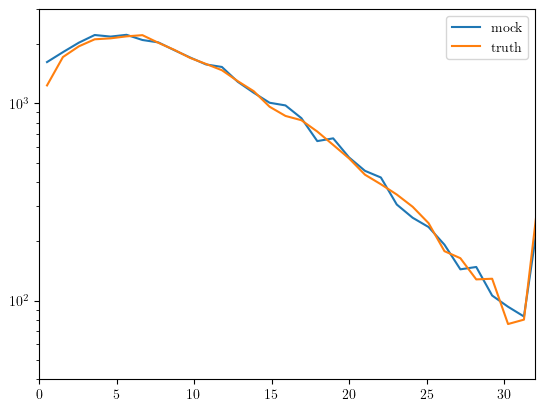

In [59]:
pl.figure()
pl.plot(bins_cents, Nhalo_all_hist, label='mock')
pl.plot(bins_cents, Nhalo_all_truth_hist, label='truth')
# _ = pl.hist(Nhalo_all_concat)
# _ = pl.hist(Nhalo_all_truth_concat)
pl.legend()
pl.yscale('log')
pl.ylim(40, 3000)
pl.xlim(0,32)




In [ ]:
pos_all_truth = []
Mhalo_all_truth = []
Nhalo_all_truth = []
# Pk_all_truth = []

BoxSize = 1000.
grid = 32
xmin = BoxSize/grid/2

MAS     = 'NGP'  #mass-assigment scheme
grid_Pk = 32
threads = 10

for jv in range(nvox_samp):
# for jv in indhigh[:nvox_samp]:    
    idx = X_val[jv]
    idx = idx.cpu().numpy().flatten()
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        Nhalo = len(idxe) + len(idx0)
        Nhalo_all_truth.append(Nhalo)
    
        if Nhalo > 0:
            try:
                Mhalo = np.zeros(Nhalo)
                pos_halo = np.zeros((Nhalo, 3))
                for jh in range(Nhalo):
                    if jh == 0:
                        Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                        for jx in range(3):
                            pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin            
                    else:
                        if Nhalo > 2:
                            Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin            
                        else:
                            Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin            

                Mhalo_all_truth.append(Mhalo)
                pos_all_truth.append(pos_halo)

                if Nhalo > 5:
                    mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                    MASL.MA(pos_halo.astype(np.float32), mesh_truth, 2*xmin, MAS)
                    mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                    Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                    Pk_all_truth.append(Pk_truth.Pk[:,0])
                else:
                    Pk_all_truth.append([])

            except:
                Mhalo_all_truth.append(np.array([]))
                pos_all_truth.append(np.array([]))
                Pk_all_truth.append([])                
                pass
        else:
            Mhalo_all_truth.append(np.array([]))
            pos_all_truth.append(np.array([]))
            Pk_all_truth.append([])                
    else:
        Nhalo_all_truth.append(np.array([]))
        Mhalo_all_truth.append(np.array([]))
        pos_all_truth.append(np.array([]))
        Pk_all_truth.append([])                


In [24]:
pos_all_truth = []
Mhalo_all_truth = []
Nhalo_all_truth = []
Pk_all_truth = []

BoxSize = 1000.
grid = 32
xmin = BoxSize/grid/2

MAS     = 'NGP'  #mass-assigment scheme
grid_Pk = 32
threads = 10

# for jv in range(nvox_samp):
for jv in indhigh[:nvox_samp]:    
    idx = X_val[jv]
    idx = idx.cpu().numpy().flatten()
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        Nhalo = len(idxe) + len(idx0)
        Nhalo_all_truth.append(Nhalo)
    
        if Nhalo > 0:
            try:
                Mhalo = np.zeros(Nhalo)
                pos_halo = np.zeros((Nhalo, 3))
                for jh in range(Nhalo):
                    if jh == 0:
                        Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                        for jx in range(3):
                            pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin            
                    else:
                        if Nhalo > 2:
                            Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin            
                        else:
                            Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin            

                Mhalo_all_truth.append(Mhalo)
                pos_all_truth.append(pos_halo)

                if Nhalo > 5:
                    mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                    MASL.MA(pos_halo.astype(np.float32), mesh_truth, 2*xmin, MAS)
                    mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                    Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                    Pk_all_truth.append(Pk_truth.Pk[:,0])
                else:
                    Pk_all_truth.append([])

            except:
                Mhalo_all_truth.append(np.array([]))
                pos_all_truth.append(np.array([]))
                Pk_all_truth.append([])                
                pass
        else:
            Mhalo_all_truth.append(np.array([]))
            pos_all_truth.append(np.array([]))
            Pk_all_truth.append([])                
    else:
        Nhalo_all_truth.append(np.array([]))
        Mhalo_all_truth.append(np.array([]))
        pos_all_truth.append(np.array([]))
        Pk_all_truth.append([])                


/tmp/ipykernel_2188932/359875854.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_2188932/359875854.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin


In [25]:
# len(Pk_all_truth)
# Pk_truth.Pk.shape, Pk_truth.k3D.shape



In [26]:
# idx_all
Nhalo_all = []
Mhalo_all = []
Pk_all = []

for jv in range(nvox_samp):
    idx = idx_all[jv]
    idx = idx.cpu().numpy().flatten()
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        Nhalo = len(idxe) + len(idx0)
        Nhalo_all.append(Nhalo)
    
        if Nhalo > 0:
            try:
                Mhalo = np.zeros(Nhalo)
                pos_halo = np.zeros((Nhalo, 3))                
                for jh in range(Nhalo):
                    if jh == 0:
                        Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                        for jx in range(3):
                            pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin            

                    else:
                        if Nhalo > 2:
                            Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin            

                        else:
                            Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin            

                Mhalo_all.append(Mhalo)

                if Nhalo > 5:
                    mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                    MASL.MA(pos_halo.astype(np.float32), mesh_truth, 2*xmin, MAS)
                    mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                    Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                    Pk_all.append(Pk_truth.Pk[:,0])
                else:
                    Pk_all.append([])


            except:
                Mhalo_all.append(np.array([]))
                Pk_all.append([])
                pass
        else:
            Mhalo_all.append(np.array([]))
            Pk_all.append([])

    else:
        Nhalo_all.append(np.array([]))
        Mhalo_all.append(np.array([]))
        Pk_all.append([])



/tmp/ipykernel_2188932/260296683.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_2188932/260296683.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin


Text(0, 0.5, '$\\Delta P(k)/P(k)$')

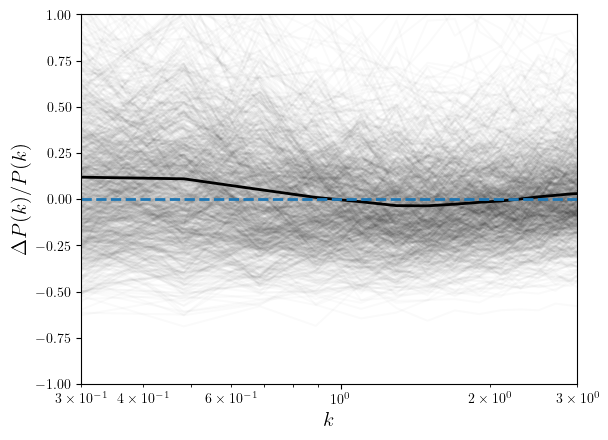

In [27]:
pl.figure()
resid_all = []
for jp in range(len(Pk_all)):
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        pl.plot(Pk_truth.k3D, (Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp], color='k', ls='-', alpha=0.02)
        resid_all.append((Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp])

resid_all = np.vstack(resid_all)
pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(0.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(-1.0, 1.0)
pl.xlim(0.3, 3)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$\Delta P(k)/P(k)$', size=15)




Text(0, 0.5, '$P(k)$')

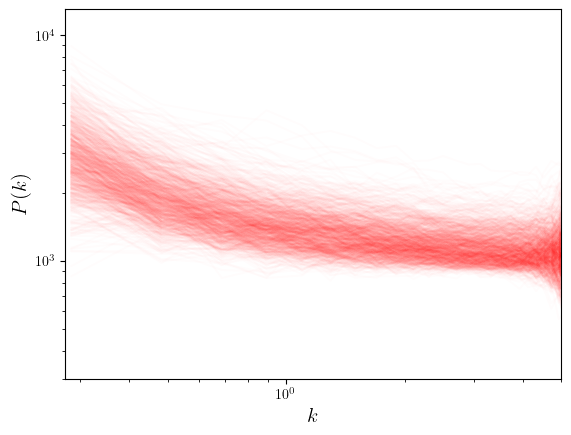

In [28]:
pl.figure()
Pktruth_mean_all = []
for jp in range(len(Pk_all)):
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        pl.plot(Pk_truth.k3D, Pk_all_truth[jp], color='r', ls='-', alpha=0.01)
        Pktruth_mean_all.append(Pk_all_truth[jp])
        # pl.plot(Pk_truth.k3D, Pk_all_truth[jp], color='b', ls='--', alpha=0.01)
        # resid_all.append((Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp])
Pktruth_mean_all = np.vstack(Pktruth_mean_all)
# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.xscale('log')
pl.yscale('log')
# pl.ylim(-0.5, 0.5)
pl.xlim(0.275, 5)
pl.ylim(3e2, 1.3e4)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$P(k)$', size=15)
# pl.title(r'Truth', size)



Text(0, 0.5, '$P(k)$')

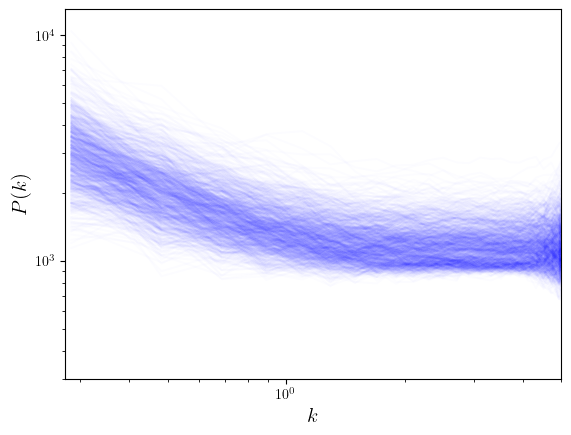

In [29]:
pl.figure()
Pk_mean_all = []
for jp in range(len(Pk_all)):
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        pl.plot(Pk_truth.k3D, Pk_all[jp], color='b', ls='-', alpha=0.01)
        Pk_mean_all.append(Pk_all[jp])
        # pl.plot(Pk_truth.k3D, Pk_all_truth[jp], color='b', ls='--', alpha=0.01)
        # resid_all.append((Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp])
Pk_mean_all = np.vstack(Pk_mean_all)
# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.xscale('log')
pl.yscale('log')
# pl.ylim(-0.5, 0.5)
pl.xlim(0.275, 5)
pl.ylim(3e2, 1.3e4)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$P(k)$', size=15)
# pl.title(r'Truth', size)



Text(0, 0.5, '$P(k)$')

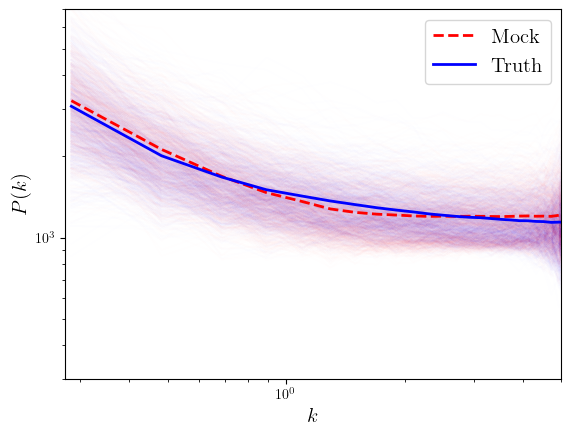

In [32]:
pl.figure()
for jp in range(len(Pk_all)):
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        pl.plot(Pk_truth.k3D, Pk_all[jp], color='r', ls='-', alpha=0.004)
        # Pk_mean_all.append(Pk_all[jp])

Pktruth_mean_all = []
for jp in range(len(Pk_all)):
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        pl.plot(Pk_truth.k3D, Pk_all_truth[jp], color='b', ls='-', alpha=0.004)
        Pktruth_mean_all.append(Pk_all_truth[jp])

# Pk_mean_all = []
# for jp in range(len(Pk_all)):
    # if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        # pl.plot(Pk_truth.k3D, Pk_all[jp], color='b', ls='-', alpha=0.01)
        # Pk_mean_all.append(Pk_all[jp])
        # pl.plot(Pk_truth.k3D, Pk_all_truth[jp], color='b', ls='--', alpha=0.01)
        # resid_all.append((Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp])
# Pk_mean_all = np.vstack(Pk_mean_all)
# resid_all = np.vstack(resid_all)
pl.plot(Pk_truth.k3D, np.mean(Pk_mean_all, axis=0), color='r', ls='--', alpha=1.0, lw=2.0, label=r'Mock')
pl.plot(Pk_truth.k3D, np.mean(Pktruth_mean_all, axis=0), color='b', ls='-', alpha=1.0, lw=2.0, label=r'Truth')
pl.xscale('log')
pl.yscale('log')
# pl.ylim(-0.5, 0.5)
pl.xlim(0.275, 5)
pl.ylim(3e2, 7e3)
pl.legend(fontsize=15)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$P(k)$', size=15)
# pl.title(r'Truth', size)



In [33]:
np.mean(Pk_mean_all, axis=0)/np.mean(Pktruth_mean_all, axis=0)


array([1.0486252 , 1.05577959, 1.00665098, 0.97575422, 0.9546787 ,
       0.93452781, 0.93591016, 0.94635405, 0.95848757, 0.96656779,
       0.97886587, 0.99196451, 1.00044523, 1.00899766, 1.0120348 ,
       1.01731845, 1.02384885, 1.03089531, 1.03986128, 1.04235678,
       1.04500534, 1.04772846, 1.05269957, 1.06006241, 1.05776604,
       1.04989725, 1.0576422 ])

In [39]:
Mhalo_all_truth_concat = []
for jv in range(len(Mhalo_all_truth)):
    Mhalo_all_truth_concat.extend(Mhalo_all_truth[jv])

Mhalo_all_concat = []
for jv in range(len(Mhalo_all)):
    Mhalo_all_concat.extend(Mhalo_all[jv])    


Text(0.5, 1.0, 'High density voxels, $\\bar{\\delta}_{{\\rm 32Mpc}/h} > 1.3$')

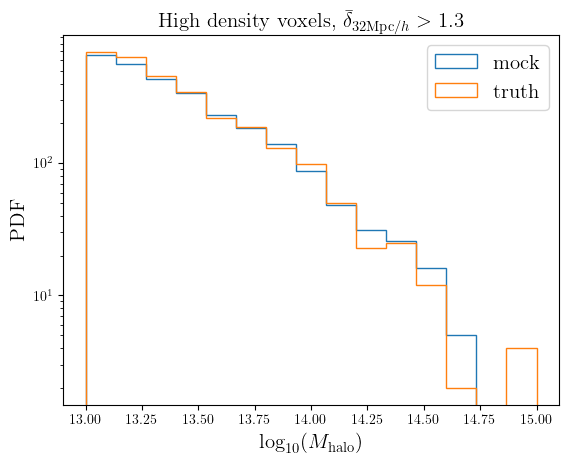

In [40]:
pl.figure()
_ = pl.hist(Mhalo_all_concat, bins=15, range=(lgMin, 15),  histtype='step', label='mock')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
_ = pl.hist(Mhalo_all_truth_concat, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)
pl.title(r'High density voxels, $\bar{\delta}_{{\rm 32Mpc}/h} > 1.3$', size=15)






In [57]:
Mhalo_all_concat_low = []
Mhalo_all_concat_mid = []
Mhalo_all_concat_high = []
for jv in indlow:
    Mhalo_all_concat_low.extend(Mhalo_all[jv])

for jv in indmid:
    Mhalo_all_concat_mid.extend(Mhalo_all[jv])

for jv in indhigh:
    Mhalo_all_concat_high.extend(Mhalo_all[jv])
    

In [58]:
# Mhalo_all_truth_concat = []
# for jv in range(len(Mhalo_all_truth)):
    # Mhalo_all_truth_concat.extend(Mhalo_all_truth[jv])

Mhalo_all_truth_concat_low = []
Mhalo_all_truth_concat_mid = []
Mhalo_all_truth_concat_high = []

for jv in indlow:
    Mhalo_all_truth_concat_low.extend(Mhalo_all_truth[jv])

for jv in indmid:
    Mhalo_all_truth_concat_mid.extend(Mhalo_all_truth[jv])

for jv in indhigh:
    Mhalo_all_truth_concat_high.extend(Mhalo_all_truth[jv])

    



Text(0.5, 1.0, 'High density voxels, $\\bar{\\delta}_{{\\rm 32Mpc}/h} > 1.3$')

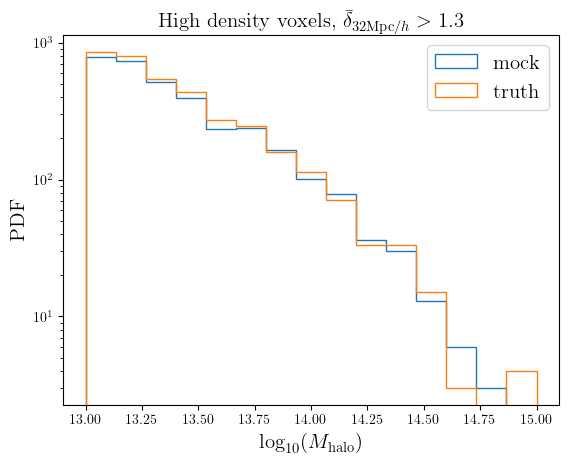

In [59]:
pl.figure()
_ = pl.hist(Mhalo_all_concat_high, bins=15, range=(lgMin, 15),  histtype='step', label='mock')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
_ = pl.hist(Mhalo_all_truth_concat_high, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)
pl.title(r'High density voxels, $\bar{\delta}_{{\rm 32Mpc}/h} > 1.3$', size=15)



Text(0.5, 1.0, 'Mid density voxels, $0.75 < \\bar{\\delta}_{{\\rm 32Mpc}/h} < 1.3$')

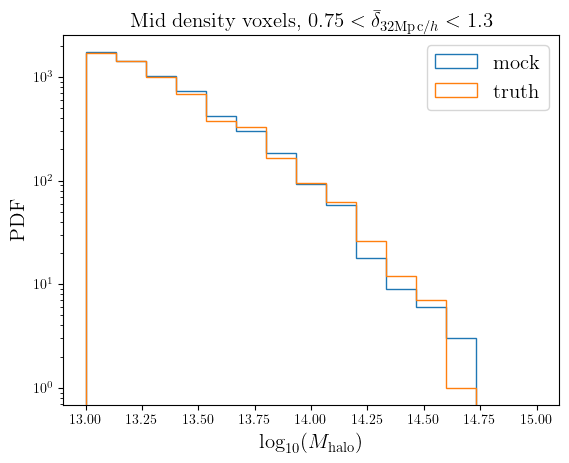

In [60]:
pl.figure()
_ = pl.hist(Mhalo_all_concat_mid, bins=15, range=(lgMin, 15), histtype='step', label='mock')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
_ = pl.hist(Mhalo_all_truth_concat_mid, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)
pl.title(r'Mid density voxels, $0.75 < \bar{\delta}_{{\rm 32Mpc}/h} < 1.3$', size=15)



Text(0.5, 1.0, 'Low density voxels, $\\bar{\\delta}_{{\\rm 32Mpc}/h} < 0.75$')

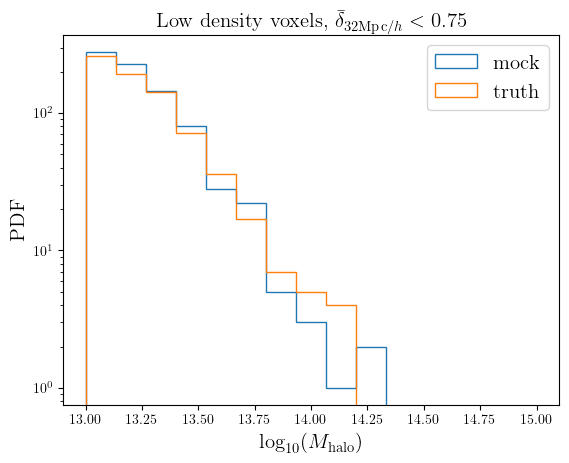

In [61]:
pl.figure()
_ = pl.hist(Mhalo_all_concat_low, bins=15, range=(lgMin, 15), histtype='step', label='mock')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
_ = pl.hist(Mhalo_all_truth_concat_low, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)
pl.title(r'Low density voxels, $\bar{\delta}_{{\rm 32Mpc}/h} < 0.75$', size=15)



In [64]:
from tqdm import tqdm
indhigh_to_plot = indhigh[::4]
idx_inp = torch.zeros((1, 1), dtype=torch.long, device=dev)
nvox_samp = len(indhigh_to_plot)
max_new_tokens = 160
end_token = 129
idx_all = []
for jv in tqdm(range(nvox_samp)):
    ind_jv = indhigh_to_plot[jv]
    DM_val_jv = DM_val[ind_jv,...]
    idx = idx_inp
    for _ in range(max_new_tokens):
        # crop idx to the last block_size tokens
        idx_cond = idx[:, -block_size:]
        # get the predictions
        logits, loss = model(idx_cond, DM_val_jv.unsqueeze(0))
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        # append sampled index to the running sequence
        if idx_next == end_token:
            break
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    idx_all.append(idx)
    



(tensor([  0,  54,  53, 121, 106, 130,  41,  11,  99,  19, 130,  20,  68, 123,
         122, 130,  19,  69, 104, 119, 130,  17, 119, 121, 117, 130,   8,  77,
         100, 110, 130,   7,  70, 125,  37, 130,   6,  54, 113,  95, 130,   5,
          83, 126,   4, 130,   2,  71, 102, 119, 129,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1], device='cuda:0'),
 tensor([[  0,  60,  59, 119, 104, 130,  44,  59, 118, 109, 130,  35,  35

In [84]:
indhigh


array([   14,    18,    20, ..., 16353, 16374, 16382])